## load warming level based data

### load all scenario-based data

In [2]:
# basic set ups, functions

from functools import partial
import xarray as xr
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cf

import os
import rioxarray
import dask

def load_filenames(fp, scenarios):
    fns = []
    for scenario in scenarios:
            fn = f"%s%s/total_%s_medium_confidence_values.nc"%(fp,scenario, scenario)
            fns.append(fn)
    return fns

def _preprocess_tide_gauge(ds):
    loc = ds.sea_level_change.locations
    tide_gauge_ind = loc[loc<1e9]
    ds = ds.sel(locations = tide_gauge_ind)
    ds['scenario'] = '0'
    return ds

def _preprocess_global_grids(ds):
    loc = ds.sea_level_change.locations
    global_grid_ind = loc[loc>=1e9]
    ds = ds.sel(locations = global_grid_ind)
    ds['scenario'] = '0'
    return ds

def read_cmip6_tas_scenario():
    """read scenario-based tas projection (from CMIP6) into one dataframe

    Returns:
        dataframe: a dataframe containing three columns: Year, Mean, Scenario
    """
    fp = "./cmip6_tas_scenario"
    df = pd.DataFrame()
    scenarios = ('historical','ssp119','ssp126', 'ssp245', 'ssp370', 'ssp585')
    for scenario in scenarios:
        fn = os.path(["%s/tas_global_%s.csv"%(fp,str.upper(scenario))])
        df_this = pd.read_csv(fn,dtype={'Year':np.int32})[['Year','Mean']]
        df_this['scenario'] = scenario
        df = pd.concat([df,df_this], ignore_index=True)
    return df

def load_raw_data(fp,scenarios,loc_str):

    fns = load_filenames(fp, scenarios)
    if loc_str == 'tide_gauge':
        partial_func = partial(lambda x: _preprocess_tide_gauge(x))
    else:
        partial_func = partial(lambda x: _preprocess_global_grids(x))   
    #reading the zarr file
    ds = xr.open_mfdataset(fns, parallel=True, preprocess=partial_func, combine = 'nested', concat_dim = 'scenario')

    ds.scenario
    ds = ds.assign_coords({"scenario": scenarios})
    return ds

os.chdir("/Users/yuting_chen/Box Sync/Yt_IP_Personal/IP_slr/")
fp = "./raw/ar6-regional-confidence/regional/confidence_output_files/medium_confidence/"
scenarios = ['ssp119','ssp126','ssp245','ssp370','ssp585']



### Pre-processing - re-format datasets and extract global grids only
The regional files contain:
* tide gauge projections
* a 1x1 degree global grid

In this script, global data corresponding to 1x1 degree global grid is extracted.
But the functionality of selecting 'tide_gauge' is also enable by switching the variable 'loc_str' from 'global_grids' to 'tide_gauge'

In [4]:
# reshape datatsets into the map format

def reshape_to_map_format(ds):
    multiindex_ds = ds.assign_coords(
        lat=np.flip(np.array(range(-90,91))), 
        lon=np.array(range(0,360)),
    ).stack(
        dim=("lat", "lon",)
    ).reset_index(
        "locations", drop=True
    ).rename(
        locations="dim"
    )
    reshaped_ds = multiindex_ds.unstack("dim")
    # reshaped_ds
    return reshaped_ds
loc_str = 'global_grids'
ds = load_raw_data(fp, scenarios, loc_str)
ds

<xarray.Dataset>
Dimensions:           (scenario: 5, locations: 65160, quantiles: 107, years: 14)
Coordinates:
  * years             (years) int32 2020 2030 2040 2050 ... 2120 2130 2140 2150
  * locations         (locations) int32 1000000000 1000000010 ... 1018003590
  * quantiles         (quantiles) float64 0.0 0.001 0.005 ... 0.995 0.999 1.0
  * scenario          (scenario) <U6 'ssp119' 'ssp126' ... 'ssp370' 'ssp585'
Data variables:
    lat               (scenario, locations) float32 dask.array<chunksize=(1, 65160), meta=np.ndarray>
    lon               (scenario, locations) float32 dask.array<chunksize=(1, 65160), meta=np.ndarray>
    sea_level_change  (scenario, quantiles, years, locations) float32 dask.array<chunksize=(1, 107, 14, 65160), meta=np.ndarray>
Attributes:
    description:  Combined confidence output file for AR6 sea-level change pr...
    history:      Created Wed Jul 14 13:47:32 2021
    source:       Files Combined: /projects/kopp/ar6/regional/pboxes/pb_1f/ss...

Reformat xarray into the ds having lat and lon coordinates
after reformatting, we will get a 5-d dataset

In [ ]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds = reshape_to_map_format(ds)
ds = ds.assign_coords({"lon": (((ds.lon + 180) % 360) - 180)}).sortby('lon')


## Pre-processing
The medium-confidence projections are available from 2020-2150 in 10-year increment.

We need bilinear interp and extrapolation to get data for years not shown in the datasets

After this, we get an interpolated SLR dataset:

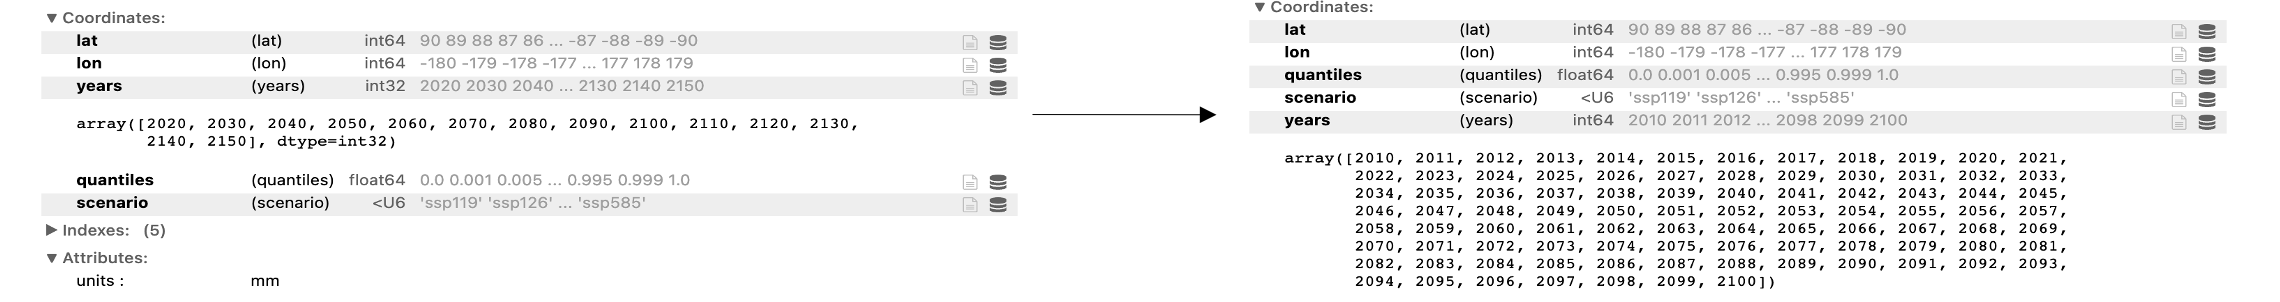

In [ ]:
%%time
ds_interp = ds.interp(years = np.arange(2010,2101), method="linear",kwargs={'fill_value':'extrapolate'}).compute()
ds_interp = ds_interp.chunk(chunks = {"scenario":5, "quantiles":"auto", "years":"auto", "lat":30, "lon":60})

ds_interp.to_zarr("/Users/yuting_chen/Box Sync/Yt_IP_Personal/IP_slr/data/slr_global_2010_2100.zarr",consolidated=True)

### Open zarr

In [9]:
ds = xr.open_zarr("/Users/yuting_chen/Box Sync/Yt_IP_Personal/IP_slr/data/slr_global_2010_2100.zarr")
ds

<xarray.Dataset>
Dimensions:           (lat: 181, lon: 360, quantiles: 107, scenario: 5,
                       years: 91)
Coordinates:
  * lat               (lat) int64 90 89 88 87 86 85 ... -85 -86 -87 -88 -89 -90
  * lon               (lon) int64 -180 -179 -178 -177 -176 ... 176 177 178 179
  * quantiles         (quantiles) float64 0.0 0.001 0.005 ... 0.995 0.999 1.0
  * scenario          (scenario) <U6 'ssp119' 'ssp126' ... 'ssp370' 'ssp585'
  * years             (years) int64 2010 2011 2012 2013 ... 2097 2098 2099 2100
Data variables:
    sea_level_change  (scenario, quantiles, years, lat, lon) float64 dask.array<chunksize=(5, 43, 43, 30, 60), meta=np.ndarray>
Attributes:
    description:  Combined confidence output file for AR6 sea-level change pr...
    history:      Created Wed Jul 14 13:47:32 2021
    source:       Files Combined: /projects/kopp/ar6/regional/pboxes/pb_1f/ss...